In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics

plt.style.use('seaborn-white')

In [2]:
# Leggiamo il dataframe dal file csv 'clienti.csv'
clienti = pd.read_csv('clienti.csv', sep=',', index_col='CustomerID')
clienti.head(3)

,Imax,Recency,Frequency,MonetaryValue,EntropyProducts
CustomerID,,,,,
12347,676,1,182,4310.00,4.464578
12348,1248,74,27,1437.24,2.987771
12349,630,18,72,1457.55,4.276666


In [3]:
clienti.describe()

,Imax,Recency,Frequency,MonetaryValue,EntropyProducts
count,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000
mean,360.635060,91.966698,89.553654,1885.037886,3.428550
std,653.166449,100.364060,219.930129,8164.189549,1.186899
min,1.000000,0.000000,1.000000,2.900000,0.000000
25%,120.000000,17.000000,17.000000,299.665000,2.708050
50%,221.500000,50.000000,40.000000,652.770000,3.515740
75%,401.250000,143.000000,97.000000,1601.487500,4.276078
max,14964.000000,373.000000,7302.000000,277460.420000,7.185612


## Creazione dei label usando l'attributo MonetaryValue

Suddividiamo i clienti in tre gruppi distinti, in base al valore dell'attributo MonetaryValue. Se un cliente ha MonetaryValue $\leq$ 300 allora è considerato "low-spending", se ha 300 $<$ MonetaryValue $\leq$ 1600 allora è considerato "medium-spending" altrimenti, se ha MonetaryValue $>$ 1600 allora è considerato "high-spending".

In [4]:
# Questa funzione dato il valore di MonetaryValue, restituisce la corrispondende etichetta
def calculate_label(m):
    if m <= 300:
        return 0 # low-spending
    if 300 < m <= 1600:
        return 1 # medium-spending
    if m > 1600:
        return 2 # high-spending
    
labels = clienti['MonetaryValue'].apply(calculate_label)

In [5]:
# Eliminiamo la colonna MonetaryValue, in quanto utilizzata per fare binning 
clienti.drop(columns=['MonetaryValue'], inplace=True)

In [6]:
clienti.head(3)

,Imax,Recency,Frequency,EntropyProducts
CustomerID,,,,
12347,676,1,182,4.464578
12348,1248,74,27,2.987771
12349,630,18,72,4.276666


## Creazione del Training Set e Test Set

Creiamo quattro dataframe che rappresentano il training set, il test set e i rispettivi labels.

In [7]:
train_set, test_set, train_label, test_label = train_test_split(clienti, labels, stratify =labels, test_size=0.30)

Inoltre definiamo due funzioni che ci serviranno per stampare i risultati ottenuti dalla classificazione.

In [8]:
# Funzioni che useremo per stampare i risultati della classificazione
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['low-spending', 'medium-spending', 'high-spending']))
    

def print_metrics(train_label, train_pred_dt, test_label, test_pred_dt):
    print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
    print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
    print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
    print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
    print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
    print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

# Standardizzazione/Normalizzazione del dataset

In seguito normalizziamo il dataset, che utilizzeremo se l'algoritmo di classificazione necessita di un dataset normalizzato.

In [9]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#scaler = MinMaxScaler()
scaler = StandardScaler()
clienti_normalized = scaler.fit_transform(clienti.values)
train_set_normalized, test_set_normalized, train_label_normalized , test_label_normalized = train_test_split(clienti_normalized, labels, stratify=labels, test_size=0.30)

# Decision Tree

In [10]:
from sklearn import tree

## Grid Search per la scelta dei parametri del Decision Tree

Applichiamo la Grid Search per la scelta dei migliori parametri per il Decision Tree.

In [11]:
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
dict_parametri = {
    "criterion": ['gini', 'entropy'],
    "splitter" : ['best'],
    "max_depth": [2, 4, 6, 8, 10, 12, None],
    "min_samples_split": [1, 2, 4, 6], # Non funziona se faccio come la prof, ma questi sono valori a caso
    "min_samples_leaf": [1, 2, 4, 6] # Non funziona se faccio come la prof, ma questi sono valori a caso
}
# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = tree.DecisionTreeClassifier()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set, train_label)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params = grid_search.best_params_

print("Migliori parametri:")
for param in best_params:
    print("   *", param, "=", best_params[param])

Migliori parametri:
   * criterion = gini
   * max_depth = 6
   * min_samples_leaf = 1
   * min_samples_split = 6
   * splitter = best


Applichiamo il Decision Tree usando i parametri trovati e lo alleniamo sul training set.

In [12]:
decision_tree = tree.DecisionTreeClassifier()
# Usiamo i parametri trovati con la grid seatch
decision_tree.set_params(**best_params)

# Alleniamo il modello sul training set
decision_tree = decision_tree.fit(train_set, train_label)

Applichiamo il Decision Tree al training set e al test set.

In [13]:
# Labels ottenuti facendo predizione sul training set
train_prediction_decision_tree = decision_tree.predict(train_set)
# Labels ottenuti facendo predizione sul test set
test_prediction_decision_tree = decision_tree.predict(test_set)

## Evaluation: metriche e confusion matrix

In [14]:
print_metrics(train_label, train_prediction_decision_tree, test_label, test_prediction_decision_tree)

Accuracy train set  0.8189028420356906
Accuracy test set  0.7688751926040062
Precision train set  0.8209800462907739
Recall train set  0.8189028420356906
F1 score train set  0.8185599667571467
Support train set  (array([0.81556196, 0.79510703, 0.87804878]), array([0.74670185, 0.86035738, 0.80845443]), array([0.77961433, 0.82644628, 0.84181568]), array([ 758, 1511,  757], dtype=int64))


In [15]:
report_scores(test_label, test_prediction_decision_tree)

                 precision    recall  f1-score   support

   low-spending       0.76      0.70      0.73       325
medium-spending       0.74      0.82      0.78       648
  high-spending       0.84      0.73      0.78       325

       accuracy                           0.77      1298
      macro avg       0.78      0.75      0.76      1298
   weighted avg       0.77      0.77      0.77      1298



Visualizziamo la Confusion Matrix.

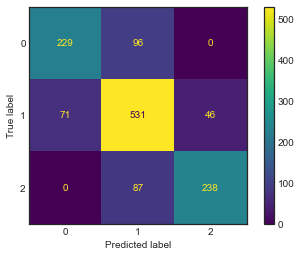

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(decision_tree, test_set, test_label)
plt.show() 

# KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

## Grid Search per la scelta dei parametri di KNN

In [18]:
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
# Ha senso scegliere weights, p e algorithm diversi?

dict_parametri = {
    "n_neighbors" : [2, 4, 6, 8, 10],
    "weights" : ['uniform', 'distance'], # vedi documentazione
    "algorithm" : ['ball_tree', 'kd_tree'], # Alternative: auto (sceglie lui il migliore), brute -> fa brute-force search
    "metric" : ['minkowski'], # è usata di default, lo metto per chiarezza. il tipo di distanza cambia in base al valore di p
    "p" : [1, 2], # 1 -> manhattan distance, 2 -> eclidean distance, 
    "n_jobs" : [-1] # Così usa il massimo grado di parallelismo possibile per fare KNN
}
# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = KNeighborsClassifier()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set, train_label)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params = grid_search.best_params_

print("Migliori parametri:")
for param in best_params:
    print("   *", param, "=", best_params[param])

Migliori parametri:
   * algorithm = ball_tree
   * metric = minkowski
   * n_jobs = -1
   * n_neighbors = 10
   * p = 1
   * weights = distance


Applichiamo KNN usando i parametri trovati e lo alleniamo sul training set.

In [19]:
knn = KNeighborsClassifier()
# Usiamo i parametri trovati con la grid seatch
knn.set_params(**best_params)
knn.fit(train_set, train_label)

KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=10, p=1,
                     weights='distance')

Applichiamo il KNN al training set e al test set.

In [20]:
# Labels ottenuti facendo predizione sul test set
test_prediction_knn = knn.predict(test_set)

## Evaluation: metriche e confusion matrix

In [21]:
report_scores(test_label, test_prediction_knn)

                 precision    recall  f1-score   support

   low-spending       0.74      0.70      0.72       325
medium-spending       0.75      0.81      0.78       648
  high-spending       0.85      0.76      0.80       325

       accuracy                           0.77      1298
      macro avg       0.78      0.75      0.76      1298
   weighted avg       0.77      0.77      0.77      1298



Visualizziamo la Confusion Matrix.

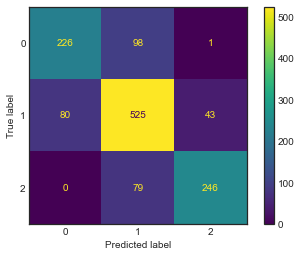

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(knn, test_set, test_label)
plt.show() 

# KNN con dataset normalizzato

In [23]:
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
# Ha senso scegliere weights, p e algorithm diversi?

dict_parametri = {
    "n_neighbors" : [2, 4, 6, 8, 10],
    "weights" : ['uniform', 'distance'], # vedi documentazione
    "algorithm" : ['ball_tree', 'kd_tree'], # Alternative: auto (sceglie lui il migliore), brute -> fa brute-force search
    "metric" : ['minkowski'], # è usata di default, lo metto per chiarezza. il tipo di distanza cambia in base al valore di p
    "p" : [1, 2], # 1 -> manhattan distance, 2 -> eclidean distance, 
    "n_jobs" : [-1] # Così usa il massimo grado di parallelismo possibile per fare KNN
}
# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = KNeighborsClassifier()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set_normalized, train_label_normalized)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params = grid_search.best_params_

print("Migliori parametri:")
for param in best_params:
    print("   *", param, "=", best_params[param])

Migliori parametri:
   * algorithm = ball_tree
   * metric = minkowski
   * n_jobs = -1
   * n_neighbors = 10
   * p = 1
   * weights = distance


In [24]:
knn = KNeighborsClassifier()
# Usiamo i parametri trovati con la grid seatch
knn.set_params(**best_params)
knn.fit(train_set_normalized, train_label_normalized)

KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=10, p=1,
                     weights='distance')

In [25]:
# Labels ottenuti facendo predizione sul test set
test_prediction_knn = knn.predict(test_set_normalized)

In [26]:
report_scores(test_label_normalized, test_prediction_knn)

                 precision    recall  f1-score   support

   low-spending       0.74      0.70      0.72       325
medium-spending       0.75      0.82      0.78       648
  high-spending       0.85      0.74      0.79       325

       accuracy                           0.77      1298
      macro avg       0.78      0.75      0.76      1298
   weighted avg       0.77      0.77      0.77      1298



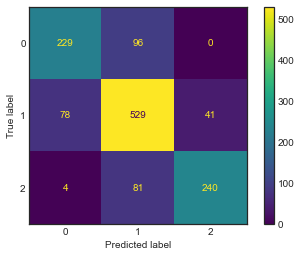

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(knn, test_set_normalized, test_label_normalized)
plt.show() 

# Naive Bayesian Classifier

Dato che il Naive Bayesian Classifier non necessita di particolari parametri, non occorre effettuale la grid search.

In [53]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
# Alleniamo il modello sul training set
gnb.fit(train_set, train_label)
# Perché qui la prof non prova a fare predizione sul training set?
# Labels ottenuti facendo predizione sul test set
test_prediction_gnb = gnb.predict(test_set)

## Evaluation: metriche e confusion matrix

In [54]:
report_scores(test_label, test_prediction_gnb)

                 precision    recall  f1-score   support

   low-spending       0.60      0.85      0.70       325
medium-spending       0.70      0.69      0.69       648
  high-spending       0.88      0.54      0.67       325

       accuracy                           0.69      1298
      macro avg       0.73      0.69      0.69      1298
   weighted avg       0.72      0.69      0.69      1298



Visualizziamo la Confusion Matrix.

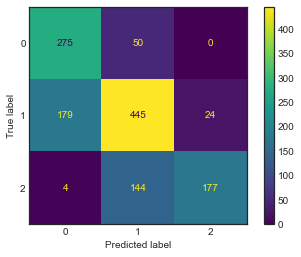

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# Perché la prof la calcola se poi non la usa?
confusion_matrix = confusion_matrix(test_label, test_prediction_knn)

plot_confusion_matrix(gnb, test_set, test_label)
plt.show() 

# Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

## Grid Search per la scelta dei parametri di Random Forest

In [33]:
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
dict_parametri = {
    "n_estimators" : [100],
    "criterion" : ['gini', 'entropy'],
    "max_depth": [8, 16, 32, None],
    "min_samples_split": [1, 2, 4, 6],
    "min_samples_leaf": [1, 2, 4, 6],
    "n_jobs" : [-1]
}
# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = RandomForestClassifier()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set, train_label)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params = grid_search.best_params_

print("Migliori parametri:")
for param in best_params:
    print("   *", param, "=", best_params[param])

Migliori parametri:
   * criterion = entropy
   * max_depth = 32
   * min_samples_leaf = 4
   * min_samples_split = 2
   * n_estimators = 100
   * n_jobs = -1


Applichiamo la Random Forest usando i parametri trovati e lo alleniamo sul training set.

In [34]:
random_forest = RandomForestClassifier()
# Usiamo i parametri trovati con la grid seatch
random_forest.set_params(**best_params)

# Alleniamo il modello sul training set
random_forest = random_forest.fit(train_set, train_label)

In [35]:
# Labels ottenuti facendo predizione sul training set
train_prediction_random_forest = random_forest.predict(train_set)
# Labels ottenuti facendo predizione sul test set
test_prediction_random_forest = random_forest.predict(test_set)

## Evaluation: metriche e confusion matrix

In [36]:
print_metrics(train_label, train_prediction_random_forest, test_label, test_prediction_random_forest)

Accuracy train set  0.9038334434897555
Accuracy test set  0.7919876733436055
Precision train set  0.9041393598497188
Recall train set  0.9038334434897555
F1 score train set  0.9038121689913474
Support train set  (array([0.89823609, 0.89311011, 0.93206522]), array([0.87335092, 0.91793514, 0.90620872]), array([0.88561873, 0.90535248, 0.91895512]), array([ 758, 1511,  757], dtype=int64))


In [37]:
report_scores(test_label, test_prediction_random_forest)

                 precision    recall  f1-score   support

   low-spending       0.77      0.71      0.74       325
medium-spending       0.77      0.83      0.80       648
  high-spending       0.87      0.79      0.83       325

       accuracy                           0.79      1298
      macro avg       0.80      0.78      0.79      1298
   weighted avg       0.79      0.79      0.79      1298



Visualizziamo la Confusion Matrix.

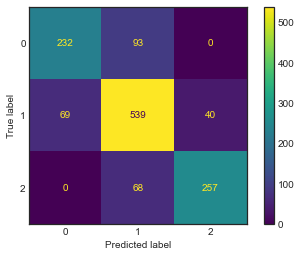

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# Perché la prof la calcola se poi non la usa?
confusion_matrix = confusion_matrix(test_label, test_prediction_random_forest)

plot_confusion_matrix(random_forest, test_set, test_label)
plt.show() 

# Rule Based (RIPPER)

In [39]:
# è necessario installare wittgenstein

In [40]:
import wittgenstein as lw

In [41]:
"""
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
dict_parametri = {
    "prune_size": [0.5, 0.6],
    "k": [1, 3, 5]
}
# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = lw.RIPPER()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set, train_label)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params = grid_search.best_params_

print("Migliori parametri:")
for param in best_params:
    print("   *", param, "=", best_params[param])
"""

'\n# Dizionario che contiene il valore i parametri da testare e i rispettivi valori\ndict_parametri = {\n    "prune_size": [0.5, 0.6],\n    "k": [1, 3, 5]\n}\n# Massimo grado di parallelismo (così usa tutti i processori)\nn_jobs= -1\n# Creiamo il modello\nclassifier = lw.RIPPER()\n# Indica il numero di folds da fare per la cross-validation\ncv = 5\n# Creiamo la grid search\ngrid_search = GridSearchCV(estimator=classifier,\n                           param_grid=dict_parametri,\n                           scoring=make_scorer(accuracy_score),\n                           n_jobs=n_jobs,\n                           cv=cv)\n# Facciamo la grid search sul train_set\ngrid_search.fit(train_set, train_label)\n# La variabile best_params contiene i miglior parametri trovati usando la grid seatch\nbest_params = grid_search.best_params_\n\nprint("Migliori parametri:")\nfor param in best_params:\n    print("   *", param, "=", best_params[param])\n'

# SVM

In [92]:
from sklearn.svm import SVC

## Grid Search per la scelta dei parametri di SVM

In [93]:
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
dict_parametri = {
    "C" : [1, 10, 100],
    "kernel" : ['rbf', 'sigmoid'],
    "gamma" : ['scale', 'auto']
}

# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = SVC()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set, train_label)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params = grid_search.best_params_

print("Migliori parametri:")
for param in best_params:
    print("   *", param, "=", best_params[param])

Migliori parametri:
   * C = 100
   * gamma = scale
   * kernel = rbf


Applichiamo l'SVM usando i parametri trovati e lo alleniamo sul training set.

In [94]:
svm = SVC()
# Usiamo i parametri trovati con la grid seatch
svm.set_params(**best_params)

# Alleniamo il modello sul training set
svm = svm.fit(train_set, train_label)

In [95]:
# Labels ottenuti facendo predizione sul training set
train_prediction_svm = svm.predict(train_set)
# Labels ottenuti facendo predizione sul test set
test_prediction_svm = svm.predict(test_set)

## Evaluation: metriche e confusion matrix

In [96]:
print_metrics(train_label, train_prediction_svm, test_label, test_prediction_svm)

Accuracy train set  0.7683410442828817
Accuracy test set  0.7580893682588598
Precision train set  0.7727975996650348
Recall train set  0.7683410442828817
F1 score train set  0.7674541321061332
Support train set  (array([0.76946108, 0.73854289, 0.8445122 ]), array([0.67810026, 0.8318994 , 0.7318362 ]), array([0.72089762, 0.78244631, 0.7841472 ]), array([ 758, 1511,  757], dtype=int64))


In [97]:
report_scores(test_label, test_prediction_svm)

                 precision    recall  f1-score   support

   low-spending       0.76      0.66      0.70       325
medium-spending       0.72      0.85      0.78       648
  high-spending       0.88      0.68      0.77       325

       accuracy                           0.76      1298
      macro avg       0.79      0.73      0.75      1298
   weighted avg       0.77      0.76      0.76      1298



Notiamo che le classi low-spending e high-spending hanno recall più bassa, quindi proviamo a migliorare la capacità predittiva del modello aggiungendo dei pesi alle classi.

In [98]:
class_weights = {
    0 : 0.375,
    1 : 0.25,
    2 : 0.375,
}
svm = SVC()
# Usiamo i parametri trovati con la grid seatch
svm.set_params(**best_params, class_weight=class_weights)

# Alleniamo il modello sul training set
svm = svm.fit(train_set, train_label)

In [99]:
# Labels ottenuti facendo predizione sul training set
train_prediction_svm = svm.predict(train_set)
# Labels ottenuti facendo predizione sul test set
test_prediction_svm = svm.predict(test_set)

## Evaluation SVM (pesi alle classi): metriche e confusion matrix

In [100]:
print_metrics(train_label, train_prediction_svm, test_label, test_prediction_svm)

Accuracy train set  0.7633840052875083
Accuracy test set  0.7542372881355932
Precision train set  0.7648966634216573
Recall train set  0.7633840052875083
F1 score train set  0.7633932458435037
Support train set  (array([0.71221282, 0.78043631, 0.78663239]), array([0.77704485, 0.73395103, 0.80845443]), array([0.74321767, 0.75648022, 0.79739414]), array([ 758, 1511,  757], dtype=int64))


In [101]:
report_scores(test_label, test_prediction_svm)

                 precision    recall  f1-score   support

   low-spending       0.70      0.77      0.73       325
medium-spending       0.76      0.74      0.75       648
  high-spending       0.81      0.76      0.79       325

       accuracy                           0.75      1298
      macro avg       0.76      0.76      0.76      1298
   weighted avg       0.76      0.75      0.75      1298



Visualizziamo la Confusion Matrix.

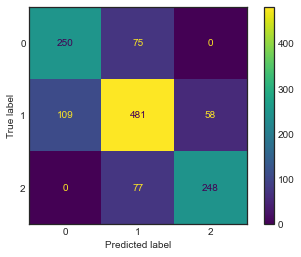

In [102]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svm, test_set, test_label)
plt.show() 

# SVM con dataset normalizzato

## Grid Search per la scelta dei parametri di SVM

In [103]:
# Dizionario che contiene il valore i parametri da testare e i rispettivi valori
dict_parametri = {
    "C" : [1, 10, 100],
    "kernel" : ['rbf', 'sigmoid'],
    "gamma" : ['scale', 'auto']
}

# Massimo grado di parallelismo (così usa tutti i processori)
n_jobs= -1
# Creiamo il modello
classifier = SVC()
# Indica il numero di folds da fare per la cross-validation
cv = 5
# Creiamo la grid search
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=dict_parametri,
                           scoring=make_scorer(accuracy_score),
                           n_jobs=n_jobs,
                           cv=cv)
# Facciamo la grid search sul train_set
grid_search.fit(train_set_normalized, train_label_normalized)
# La variabile best_params contiene i miglior parametri trovati usando la grid seatch
best_params = grid_search.best_params_

print("Migliori parametri:")
for param in best_params:
    print("   *", param, "=", best_params[param])

Migliori parametri:
   * C = 100
   * gamma = auto
   * kernel = rbf


Applichiamo l'SVM usando i parametri trovati e lo alleniamo sul training set.

In [104]:
svm = SVC()
# Usiamo i parametri trovati con la grid seatch
svm.set_params(**best_params, class_weight=class_weights)

# Alleniamo il modello sul training set
svm = svm.fit(train_set_normalized, train_label_normalized)

In [105]:
# Labels ottenuti facendo predizione sul training set
train_prediction_svm = svm.predict(train_set_normalized)
# Labels ottenuti facendo predizione sul test set
test_prediction_svm = svm.predict(test_set_normalized)

In [106]:
print_metrics(train_label_normalized, train_prediction_svm, test_label_normalized, test_prediction_svm)

Accuracy train set  0.7957699933906147
Accuracy test set  0.8035439137134053
Precision train set  0.7984558682395718
Recall train set  0.7957699933906147
F1 score train set  0.7961409684222811
Support train set  (array([0.71919431, 0.81638418, 0.84203655]), array([0.80079156, 0.76505625, 0.85204756]), array([0.75780275, 0.78988726, 0.84701248]), array([ 758, 1511,  757], dtype=int64))


In [107]:
report_scores(test_label_normalized, test_prediction_svm)

                 precision    recall  f1-score   support

   low-spending       0.75      0.79      0.77       325
medium-spending       0.81      0.79      0.80       648
  high-spending       0.85      0.84      0.84       325

       accuracy                           0.80      1298
      macro avg       0.80      0.81      0.80      1298
   weighted avg       0.80      0.80      0.80      1298



Visualizziamo la Confusion Matrix.

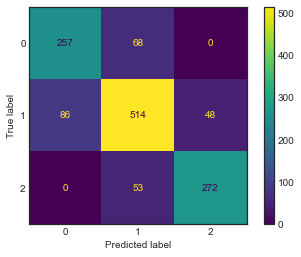

In [114]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svm, test_set_normalized, test_label_normalized)
plt.show() 

# SVM con dataset normalizzato (con pesi alle classi)

In [109]:
svm = SVC()
# Usiamo i parametri trovati con la grid seatch
class_weights = {
    0 : 0.375,
    1 : 0.25,
    2 : 0.375,
}
svm.set_params(**best_params, class_weight=class_weights)

# Alleniamo il modello sul training set
svm = svm.fit(train_set_normalized, train_label_normalized)

In [110]:
# Labels ottenuti facendo predizione sul training set
train_prediction_svm = svm.predict(train_set_normalized)
# Labels ottenuti facendo predizione sul test set
test_prediction_svm = svm.predict(test_set_normalized)

In [111]:
print_metrics(train_label_normalized, train_prediction_svm, test_label_normalized, test_prediction_svm)

Accuracy train set  0.7957699933906147
Accuracy test set  0.8035439137134053
Precision train set  0.7984558682395718
Recall train set  0.7957699933906147
F1 score train set  0.7961409684222811
Support train set  (array([0.71919431, 0.81638418, 0.84203655]), array([0.80079156, 0.76505625, 0.85204756]), array([0.75780275, 0.78988726, 0.84701248]), array([ 758, 1511,  757], dtype=int64))


In [112]:
report_scores(test_label_normalized, test_prediction_svm)

                 precision    recall  f1-score   support

   low-spending       0.75      0.79      0.77       325
medium-spending       0.81      0.79      0.80       648
  high-spending       0.85      0.84      0.84       325

       accuracy                           0.80      1298
      macro avg       0.80      0.81      0.80      1298
   weighted avg       0.80      0.80      0.80      1298



Visualizziamo la Confusion Matrix.

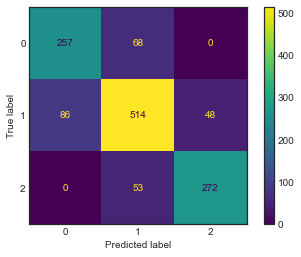

In [115]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svm, test_set_normalized, test_label_normalized)
plt.show() 